In [ ]:
!pip install easyocr Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 kB 28.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from sklearn.metrics import precision_score, recall_score, f1_score
from Levenshtein import distance as levenshtein_distance
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Функция для парсинга GT файлов
def parse_gt_file(gt_file_path):
    gt_boxes = []
    gt_texts = []
    with open(gt_file_path, 'r') as f:
        for line in f:
            parts = line.strip().replace(',', '').split()
            x1, y1, x2, y2 = map(int, parts[:4])
            text = ' '.join(parts[4:])  # Текст после координат
            gt_boxes.append([x1, y1, x2, y2])
            gt_texts.append(text)
    return np.array(gt_boxes), gt_texts

In [ ]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

    # Функция для удаления кавычек из текста
def remove_quotes(text):
    return text.replace('"', '').replace("'", "")

# Функция для расчета CER (Character Error Rate)
def calculate_cer(pred_text, gt_text):
    if not gt_text:
        return 1.0  # Если GT текст пустой, CER = 1 (максимальная ошибка)
    # Удаляем кавычки из текстов
    pred_text = remove_quotes(pred_text)
    gt_text = remove_quotes(gt_text)
    return levenshtein_distance(pred_text, gt_text) / max(len(gt_text), 1)

# Функция для расчета WER (Word Error Rate)
def calculate_wer(pred_text, gt_text):
    if not gt_text:
        return 1.0  # Если GT текст пустой, WER = 1 (максимальная ошибка)
    # Удаляем кавычки из текстов
    pred_text = remove_quotes(pred_text)
    gt_text = remove_quotes(gt_text)
    gt_words = gt_text.split()
    pred_words = pred_text.split()
    if not gt_words:
        return 1.0  # Если GT текст пустой, WER = 1 (максимальная ошибка)
    return levenshtein_distance(pred_words, gt_words) / max(len(gt_words), 1)


In [ ]:
# Загрузка модели Faster R-CNN из файла
def load_model(model_path, num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
    model.eval()
    return model

In [ ]:
# Загрузка модели
model_path = '/content/drive/MyDrive/FASTER_R-CNN_CV_PROJECT/faster_rcnn_text_detection_100epoch.pth'
model = load_model(model_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]
<ipython-input-2-da4ccf86ca42>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/

In [ ]:
# Загрузка изображения
image_path = '/content/drive/MyDrive/ICDAR2013/Challenge2_Test_Task12_Images/img_26.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# Преобразование изображения в тензор
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image)

# Применение модели к изображению
with torch.no_grad():
    prediction = model([image_tensor])


In [ ]:
# Получение bounding boxes из предсказания
pred_boxes = prediction[0]['boxes'].cpu().numpy().astype(int)

In [ ]:
# Загрузка ground truth bounding boxes и текстов
gt_file_path = '/content/drive/MyDrive/ICDAR2013/Challenge2_Test_Task1_GT (1)/gt_img_26.txt'
gt_boxes, gt_texts = parse_gt_file(gt_file_path)

In [ ]:
# Инициализация EasyOCR
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

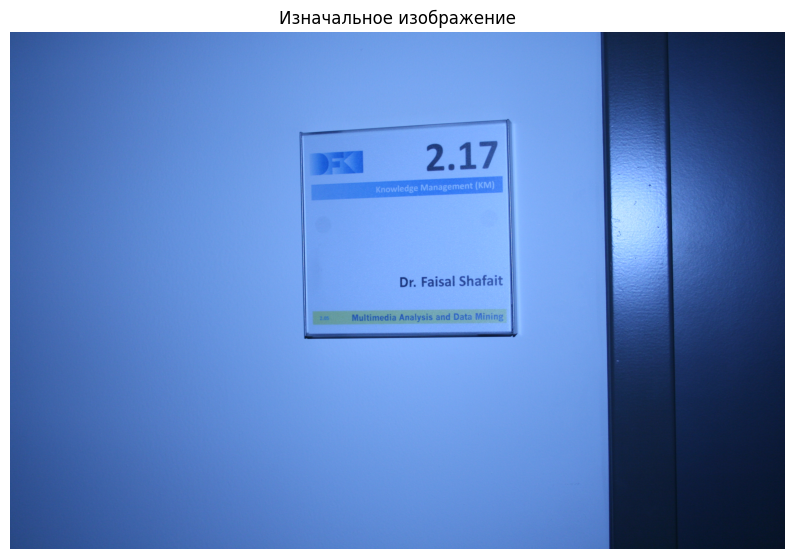

In [ ]:
# Визуализация изначального изображения
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Изначальное изображение")
plt.axis('off')
plt.show()


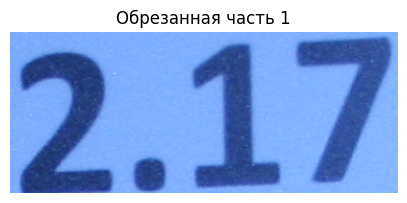

Обрезанная часть 1:
GT текст: "2.17"
Распознанный текст: 2.17
CER: 0.0000, WER: 0.0000


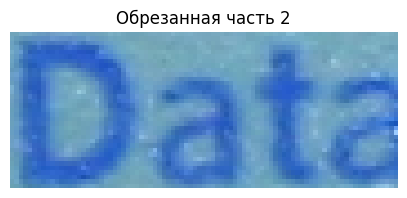

Обрезанная часть 2:
GT текст: "Data"
Распознанный текст: Datz
CER: 0.2500, WER: 1.0000


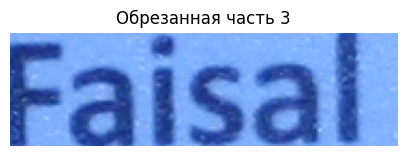

Обрезанная часть 3:
GT текст: "Faisal"
Распознанный текст: Faisal
CER: 0.0000, WER: 0.0000


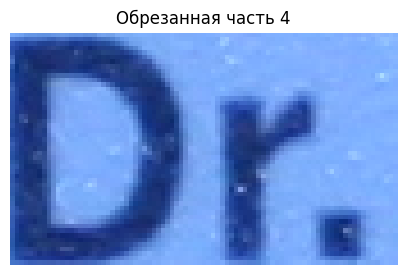

Обрезанная часть 4:
GT текст: "Dr."
Распознанный текст: Dr
CER: 0.3333, WER: 1.0000


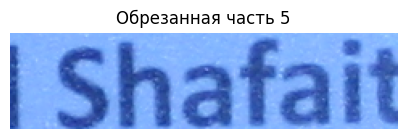

Обрезанная часть 5:
GT текст: "Shafait"
Распознанный текст: Shafait
CER: 0.0000, WER: 0.0000


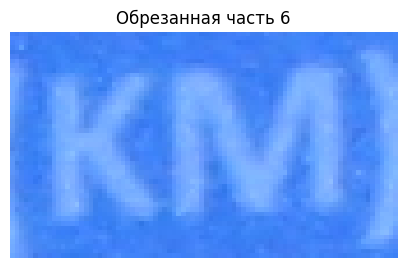

Обрезанная часть 6:
GT текст: "(KM)"
Распознанный текст: Km;
CER: 0.7500, WER: 1.0000


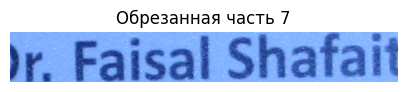

Обрезанная часть 7: GT текст недоступен


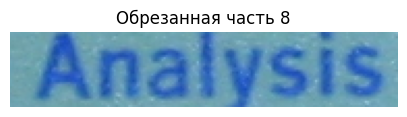

Обрезанная часть 8:
GT текст: "Analysis"
Распознанный текст: Analvsis
CER: 0.1250, WER: 1.0000


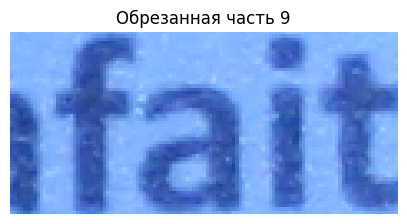

Обрезанная часть 9:
GT текст: "Shafait"
Распознанный текст: fait
CER: 0.4286, WER: 1.0000


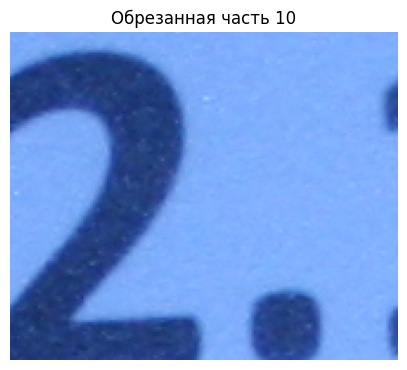

Обрезанная часть 10: GT текст недоступен


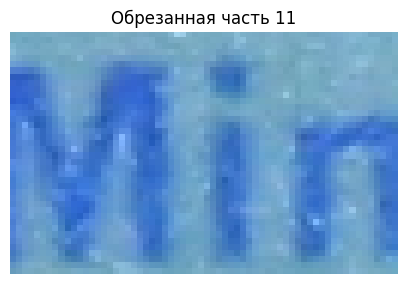

Обрезанная часть 11: GT текст недоступен
Средний CER: 0.2359
Средний WER: 0.6250


In [ ]:
# Сопоставление предсказанных bbox с ground truth bbox на основе IoU
cer_list, wer_list = [], []
for i, pred_box in enumerate(pred_boxes):
    # Находим ground truth bbox с максимальным IoU
    ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
    best_match_idx = np.argmax(ious) if ious else -1

    if best_match_idx != -1 and ious[best_match_idx] > 0.5:  # Порог IoU = 0.5
        gt_text = gt_texts[best_match_idx]
    else:
        gt_text = ""  # Если соответствие не найдено

    # Обрезаем изображение по предсказанному bbox
    x1, y1, x2, y2 = pred_box
    cropped_image = image[y1:y2, x1:x2]

    # Визуализация обрезанной части
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image)
    plt.title(f"Обрезанная часть {i+1}")
    plt.axis('off')
    plt.show()

    # Распознавание текста с помощью EasyOCR
    result = reader.readtext(cropped_image)
    pred_text = ' '.join([res[1] for res in result])  # Объединяем все распознанные тексты

    # Расчет CER и WER
    if gt_text:
        cer = calculate_cer(pred_text, gt_text)
        wer = calculate_wer(pred_text, gt_text)
        cer_list.append(cer)
        wer_list.append(wer)
        print(f"Обрезанная часть {i+1}:")
        print(f"GT текст: {gt_text}")
        print(f"Распознанный текст: {pred_text}")
        print(f"CER: {cer:.4f}, WER: {wer:.4f}")
    else:
        print(f"Обрезанная часть {i+1}: GT текст недоступен")

# Средние значения CER и WER
if cer_list and wer_list:
    print(f"Средний CER: {np.mean(cer_list):.4f}")
    print(f"Средний WER: {np.mean(wer_list):.4f}")
else:
    print("Нет данных для расчета CER и WER.")

In [ ]:
# Пути к папкам с изображениями и GT файлами
images_dir = '/content/drive/MyDrive/ICDAR2013/Challenge2_Test_Task12_Images'
gt_dir = '/content/drive/MyDrive/ICDAR2013/Challenge2_Test_Task1_GT (1)'

In [ ]:
# Списки для хранения метрик
all_cer = []
all_wer = []

# Проход по всем изображениям в папке
for image_name in os.listdir(images_dir):
    if not image_name.startswith('img_') or not image_name.endswith('.jpg'):
        continue  # Пропускаем файлы, не соответствующие шаблону img_номер.jpg

    # Извлечение номера из имени изображения
    image_number = image_name.split('_')[1].split('.')[0]

    # Формирование имени GT файла
    gt_file_name = f'gt_img_{image_number}.txt'
    gt_file_path = os.path.join(gt_dir, gt_file_name)

    # Проверка существования GT файла
    if not os.path.exists(gt_file_path):
        print(f"GT файл для изображения {image_name} не найден.")
        continue

    # Загрузка изображения
    image_path = os.path.join(images_dir, image_name)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_name}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Преобразование изображения в тензор
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image)

    # Применение модели к изображению
    with torch.no_grad():
        prediction = model([image_tensor])

    # Получение bounding boxes из предсказания
    pred_boxes = prediction[0]['boxes'].cpu().numpy().astype(int)

    # Загрузка ground truth bounding boxes и текстов
    gt_boxes, gt_texts = parse_gt_file(gt_file_path)

    # Сопоставление предсказанных bbox с ground truth bbox на основе IoU
    cer_list, wer_list = [], []
    for pred_box in pred_boxes:
        # Находим ground truth bbox с максимальным IoU
        ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
        best_match_idx = np.argmax(ious) if ious else -1

        if best_match_idx != -1 and ious[best_match_idx] > 0.5:  # Порог IoU = 0.5
            gt_text = gt_texts[best_match_idx]
        else:
            gt_text = ""  # Если соответствие не найдено

        # Обрезаем изображение по предсказанному bbox
        x1, y1, x2, y2 = pred_box
        cropped_image = image[y1:y2, x1:x2]

        # Распознавание текста с помощью EasyOCR
        result = reader.readtext(cropped_image)
        pred_text = ' '.join([res[1] for res in result])  # Объединяем все распознанные тексты

        # Расчет CER и WER
        if gt_text:
            cer = calculate_cer(pred_text, gt_text)
            wer = calculate_wer(pred_text, gt_text)
            cer_list.append(cer)
            wer_list.append(wer)

    # Усреднение метрик для текущего изображения
    if cer_list and wer_list:
        all_cer.append(np.mean(cer_list))
        all_wer.append(np.mean(wer_list))

In [ ]:
# Средние значения CER и WER для всего датасета
if all_cer and all_wer:
    print(f"Средний CER для датасета: {np.mean(all_cer):.4f}")
    print(f"Средний WER для датасета: {np.mean(all_wer):.4f}")
else:
    print("Нет данных для расчета CER и WER.")

Средний CER для датасета: 0.3615
Средний WER для датасета: 0.6907
